In [75]:
#import libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

## EDA

In [6]:
# Define paths
train_dir = 'chest_xray/train/'
val_dir = 'chest_xray/val/'
test_dir = 'chest_xray/test/'

In [7]:
train_normal_count = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
train_pneumonia_count = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
val_normal_count = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
val_pneumonia_count = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
test_normal_count = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
test_pneumonia_count = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))

print("Train Data:")
print(f"Normal Images: {train_normal_count}")
print(f"Pneumonia Images: {train_pneumonia_count}")

print("\nValidation Data:")
print(f"Normal Images: {val_normal_count}")
print(f"Pneumonia Images: {val_pneumonia_count}")

print("\nTest Data:")
print(f"Normal Images: {test_normal_count}")
print(f"Pneumonia Images: {test_pneumonia_count}")

Train Data:
Normal Images: 1341
Pneumonia Images: 3875

Validation Data:
Normal Images: 8
Pneumonia Images: 8

Test Data:
Normal Images: 234
Pneumonia Images: 390


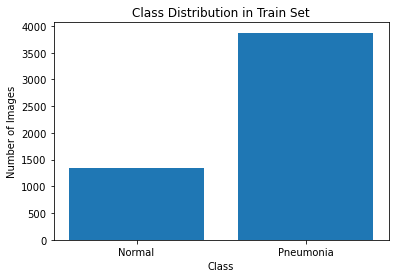

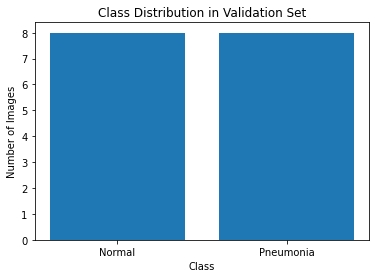

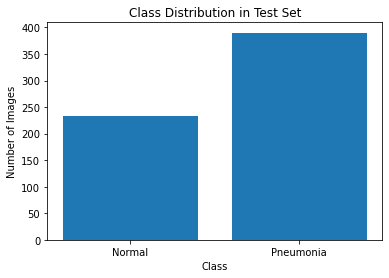

In [8]:
# Function to plot class distribution
def plot_class_distribution(normal_count, pneumonia_count, set_name):
    plt.bar(['Normal', 'Pneumonia'], [normal_count, pneumonia_count])
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title(f'Class Distribution in {set_name} Set')
    plt.show()

# Plot class distribution for each set
plot_class_distribution(train_normal_count, train_pneumonia_count, 'Train')
plot_class_distribution(val_normal_count, val_pneumonia_count, 'Validation')
plot_class_distribution(test_normal_count, test_pneumonia_count, 'Test')

## Designing the Model 

In [55]:
# Preprocess the images into tensors
# Rescale the data by 1/.255 and use binary_crossentropy loss

from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=5216,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                        target_size=(150, 150),
                                                        batch_size=16,
                                                        class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size=(150, 150),
                                                        batch_size=624,
                                                        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [56]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Label: 1.0


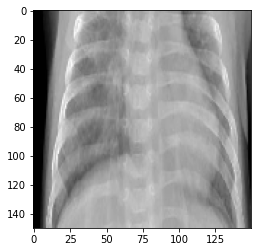

In [77]:
sample_image = train_images[1]
sample_label = train_labels[1]
display(plt.imshow(sample_image))
print('Label: {}'.format(sample_label))

In [85]:
# Get value counts
unique_elements, counts = np.unique(train_labels, return_counts=True)

# Combine the unique elements and their counts into a dictionary
value_counts_dict = dict(zip(unique_elements, counts))

# Print the result
print(value_counts_dict)

{0.0: 1341, 1.0: 3875}


In [57]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 150, 150, 3)
train_labels shape: (5216,)
test_images shape: (624, 150, 150, 3)
test_labels shape: (624,)
val_images shape: (16, 150, 150, 3)
val_labels shape: (16,)


In [58]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 67500)
(624, 67500)
(16, 67500)


In [60]:
train_y = np.reshape(train_labels, (5216,1))
test_y = np.reshape(test_labels, (624,1))
val_y = np.reshape(val_labels, (16,1))

In [61]:
# Build a baseline fully connected model
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(67500,))) # 2 hidden layers
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [62]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/50
163/163 [==============================] - 5s 28ms/step - loss: 0.4916 - accuracy: 0.7627 - val_loss: 0.6781 - val_accuracy: 0.6250
Epoch 2/50
163/163 [==============================] - 3s 15ms/step - loss: 0.3561 - accuracy: 0.8604 - val_loss: 0.5891 - val_accuracy: 0.8125
Epoch 3/50
163/163 [==============================] - 2s 15ms/step - loss: 0.3063 - accuracy: 0.8923 - val_loss: 0.5331 - val_accuracy: 0.8125
Epoch 4/50
163/163 [==============================] - 2s 15ms/step - loss: 0.2731 - accuracy: 0.9051 - val_loss: 0.4782 - val_accuracy: 0.8750
Epoch 5/50
163/163 [==============================] - 2s 15ms/step - loss: 0.2546 - accuracy: 0.9158 - val_loss: 0.5683 - val_accuracy: 0.8125
Epoch 6/50
163/163 [==============================] - 2s 14ms/step - loss: 0.2433 - accuracy: 0.9208 - val_loss: 0.5537 - val_accuracy: 0.8125
Epoch 7/50
163/163 [==============================] - 3s 17ms/step - loss: 0.2273 - accuracy: 0.9273 - val_loss: 0.5323 - val_accuracy: 0.8125

In [63]:
results_train = model.evaluate(train_img, train_y)

163/163 [==============================] - 1s 9ms/step - loss: 0.0808 - accuracy: 0.9743


In [64]:
results_test = model.evaluate(test_img, test_y)

20/20 [==============================] - 0s 19ms/step - loss: 0.9336 - accuracy: 0.7724


In [86]:
print('Train Results:', results_train)
print('Test Results:', results_test)

Train Results: [0.08080942183732986, 0.9743098020553589]
Test Results: [0.9335736036300659, 0.7724359035491943]


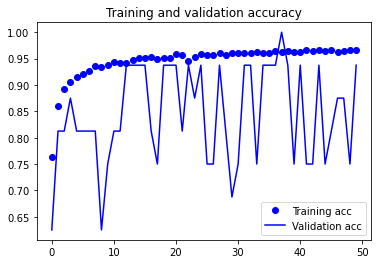

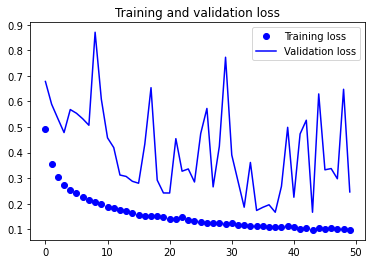

In [73]:
# Plot history

import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Baseline model seemed to show some degree of overfitting. 
- Train Accuracy: 0.97
- Test Accuracy: 0.77

## Building a CNN

In [70]:
# Design the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [ ]:
# Model will take a good amount of time to run ~1-2 minutes per epoch
history = model.fit(train_images,
                    train_y,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_images, val_y))

## Using Data Augmentation 

ImageDataGenerator() becomes really useful when we actually want to generate more data. 


In [87]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)

In [90]:
# get all the data in the directory split/test , and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_dir, 
        target_size=(64, 64), 
        batch_size = 624,
        class_mode='binary') 

# get all the data in the directory split/validation , and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_dir, 
        target_size=(64, 64),
        batch_size = 32,
        class_mode='binary')

# get all the data in the directory split/train, and reshape them
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(64, 64), 
        batch_size = 32, 
        class_mode='binary')

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150 , 150,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer= 'sgd',
              metrics=['acc'])

In [ ]:
history_2 = model.fit(train_generator,
                      epochs=30,
                      validation_data=val_generator)

In [ ]:
test_x, test_y = next(test_generator)

In [ ]:
results_test = model.evaluate(test_x, test_y)
results_test